In [2]:
# These are all the modules we'll be using later.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import scipy.io   
import h5py

import matplotlib.pyplot as plt

import os
import sys
import tarfile
from IPython.display import display, Image

from scipy import ndimage

import random

%matplotlib inline

In [46]:
pickle_file = 'SVHN_single_grey.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_label = save['train_label']
    valid_dataset = save['valid_dataset']
    valid_label = save['valid_label']
    test_dataset = save['test_dataset']
    test_label = save['test_label']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_label.shape)
    print('Validation set', valid_dataset.shape, valid_label.shape)
    print('Test set', test_dataset.shape, test_label.shape)

Training set (65257, 32, 32) (65257,)
Validation set (10000, 32, 32) (10000,)
Test set (26032, 32, 32) (26032,)


In [47]:
def disp_sample_dataset(dataset, label):
    items = random.sample(range(dataset.shape[0]), 8)
    for i, item in enumerate(items):
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        plt.title(label[i])
        plt.imshow(dataset[i])

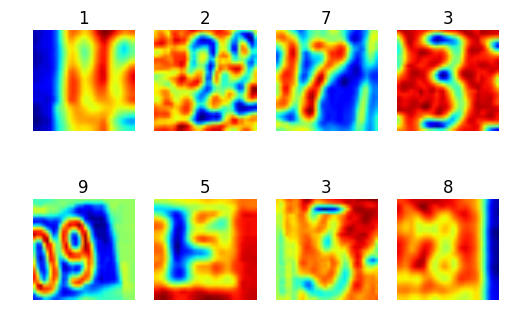

In [48]:
disp_sample_dataset(train_dataset, train_label)

In [6]:
pickle_file = 'SVHN_single_GCN.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_label = save['train_label']
    valid_dataset = save['valid_dataset']
    valid_label = save['valid_label']
    test_dataset = save['test_dataset']
    test_label = save['test_label']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_label.shape)
    print('Validation set', valid_dataset.shape, valid_label.shape)
    print('Test set', test_dataset.shape, test_label.shape)

Training set (65257, 32, 32) (65257,)
Validation set (10000, 32, 32) (10000,)
Test set (26032, 32, 32) (26032,)


In [7]:
image_size = 32
num_labels = 11 # 0-9, + blank 
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
    dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
    
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_label = reformat(train_dataset, train_label)
valid_dataset, valid_label = reformat(valid_dataset, valid_label)
test_dataset, test_label = reformat(test_dataset, test_label)
print('Training set', train_dataset.shape, train_label.shape)
print('Validation set', valid_dataset.shape, valid_label.shape)
print('Test set', test_dataset.shape, test_label.shape)

Training set (65257, 32, 32, 1) (65257, 11)
Validation set (10000, 32, 32, 1) (10000, 11)
Test set (26032, 32, 32, 1) (26032, 11)


In [8]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [12]:
test_dataset1 = test_dataset
test_label1 = test_label

In [13]:
test_dataset = test_dataset[:6000,:]
test_label = test_label[:6000,:]
print('Test set', test_dataset.shape, test_label.shape)

Test set (6000, 32, 32, 1) (6000, 11)


In [14]:
batch_size = 128
patch_size = 5
depth1 = 16
depth2 = 32
num_hidden = 1024

graph = tf.Graph()

with graph.as_default():

    def weight_varible(shape):
        initial = tf.truncated_normal(shape, stddev = 0.1)
        return tf.Variable(initial)

    def bias_varible(shape):
        initial = tf.constant(0.1, shape = shape)
        return tf.Variable(initial)
    
    def conv2d(data, weight):
        # strides [1, x_movement, y_movement, 1]
        return tf.nn.conv2d(data, weight, strides = [1, 1, 1, 1], padding = 'SAME')

    def max_pooling(data):
        return tf.nn.max_pool(data, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    
    
    # Input data.
    tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    
    # Varibles
    # conv1 layer 1
    layer1_weights = weight_varible([patch_size, patch_size, num_channels, depth1])
    layer1_biases = bias_varible([depth1]) # 16
    # conv2 layer 2
    layer2_weights = weight_varible([patch_size, patch_size, depth1, depth2]) # in depth1, out depth2
    layer2_biases = bias_varible([depth2]) # 32
    # func1 layer 3
    layer3_weights = weight_varible([image_size // 4 * image_size // 4 * depth2, num_hidden])
    layer3_biases = bias_varible([num_hidden])
    # func2 layer 4
    layer4_weights = weight_varible([num_hidden, num_labels])
    layer4_biases = bias_varible([num_labels])
    
    global_step = tf.Variable(0)  # count the number of steps taken.
    
    def model(dataset):
        # conv1 layer 1
        hidden1 = tf.nn.relu(conv2d(dataset, layer1_weights) + layer1_biases) # 32 * 32 * depth1
        pool1 = max_pooling(hidden1) # 16 * 16 * depth1
        # conv2 layer 2
        hidden2 = tf.nn.relu(conv2d(pool1, layer2_weights) + layer2_biases) # 16 * 16 * depth2
        pool2 = max_pooling(hidden2) # 8 * 8 * depth2
        
        shape = pool2.get_shape().as_list()
        pool2_flat = tf.reshape(pool2, [shape[0], shape[1] * shape[2] * shape[3]])

#         print([shape[0], shape[1] * shape[2] * shape[3]])
#         print([image_size // 4 * image_size // 4 * depth2, num_hidden])
        
        # func1 layer 3
        hidden3 = tf.nn.relu(tf.matmul(pool2_flat, layer3_weights) + layer3_biases)
        hidden3_drop = tf.nn.dropout(hidden3, 0.5)
        # func2 layer 4
        prediction = tf.matmul(hidden3_drop, layer4_weights) + layer4_biases
        return prediction
    
    
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer.
#     learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [15]:
num_steps = 10001

with tf.Session(graph=graph) as session:
    writer = tf.train.SummaryWriter("logs/", session.graph)
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_label.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_label[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
            valid_prediction.eval(), valid_label))
    
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_label))

Initialized
Minibatch loss at step 0: 15.628929
Minibatch accuracy: 7.8%
Validation accuracy: 15.1%
Minibatch loss at step 500: 2.077304
Minibatch accuracy: 28.9%
Validation accuracy: 30.3%
Minibatch loss at step 1000: 0.942447
Minibatch accuracy: 69.5%
Validation accuracy: 71.0%
Minibatch loss at step 1500: 0.664422
Minibatch accuracy: 82.0%
Validation accuracy: 80.0%
Minibatch loss at step 2000: 0.622747
Minibatch accuracy: 78.1%
Validation accuracy: 82.2%
Minibatch loss at step 2500: 0.516402
Minibatch accuracy: 87.5%
Validation accuracy: 84.1%
Minibatch loss at step 3000: 0.246544
Minibatch accuracy: 93.8%
Validation accuracy: 84.9%
Minibatch loss at step 3500: 0.329750
Minibatch accuracy: 91.4%
Validation accuracy: 85.9%
Minibatch loss at step 4000: 0.517766
Minibatch accuracy: 85.2%
Validation accuracy: 85.5%
Minibatch loss at step 4500: 0.453663
Minibatch accuracy: 87.5%
Validation accuracy: 86.0%
Minibatch loss at step 5000: 0.410853
Minibatch accuracy: 89.8%
Validation accurac